In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# # extract data from zip file
# import zipfile
# import os

# # Define the path to your zip file and the directory where you want to extract it
# zip_file_path = '/content/drive/MyDrive/465 Project/Splitted.zip'
# extract_folder_path = '/content/drive/MyDrive/465 Project/ManualDataset'

# os.makedirs(extract_folder_path, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder_path)

#Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import time
import math
from functools import partial
from typing import Optional, Callable

In [4]:
!pip install mamba-ssm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached

In [5]:
from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, selective_scan_ref

In [6]:
!pip install einops

In [7]:
!pip install yacs

In [8]:
from PIL import Image

In [9]:
from einops import rearrange, repeat

In [10]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.1 MB/s eta 0:00:00


In [11]:
!pip install medpy
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.5 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.1-cp310-cp310-linux_x86_64.whl size=762864 sha256=9b33122228c020b0e3d7f5fd06fc8bfd3aa4310fa3da6c75295771f15fa4d6b4
  Stored in directory: /root/.cache/pip/wheels/e6/8f/f9/7fec657d34ad3ebd2ea3ca5ad0e526f8fea93c3fb4a26c3416
Successfully built medpy


In [12]:
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

#More Imports

In [13]:
import time
import math
from functools import partial
from typing import Optional, Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from einops import rearrange, repeat
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
try:
    from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, selective_scan_ref
except:
    pass

# an alternative for mamba_ssm (in which causal_conv1d is needed)
try:
    from selective_scan import selective_scan_fn as selective_scan_fn_v1
    from selective_scan import selective_scan_ref as selective_scan_ref_v1
except:
    pass

DropPath.__repr__ = lambda self: f"timm.DropPath({self.drop_prob})"

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn4 = nn.BatchNorm2d(out_channels)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv_pool = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_out = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn_out = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.bn1(self.conv1(x)))
        x2 = self.relu(self.bn2(self.conv2(x)))
        x3 = self.relu(self.bn3(self.conv3(x)))
        x4 = self.relu(self.bn4(self.conv4(x)))

        x5 = self.avg_pool(x)
        x5 = self.conv_pool(x5)
        x5 = F.interpolate(x5, size=x.shape[2:], mode='bilinear', align_corners=False)

        x = torch.cat([x1, x2, x3, x4, x5], dim=1)
        x = self.relu(self.bn_out(self.conv_out(x)))
        return x



class PatchEmbed2D(nn.Module):
    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None, **kwargs):
        super().__init__()
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else None

    def forward(self, x):
        x = self.proj(x).permute(0, 2, 3, 1)
        if self.norm:
            x = self.norm(x)
        return x

class PatchMerging2D(nn.Module):
    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        B, H, W, C = x.shape

        SHAPE_FIX = [-1, -1]
        if (W % 2 != 0) or (H % 2 != 0):
            print(f"Warning, x.shape {x.shape} is not match even ===========", flush=True)
            SHAPE_FIX[0] = H // 2
            SHAPE_FIX[1] = W // 2

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C

        if SHAPE_FIX[0] > 0:
            x0 = x0[:, :SHAPE_FIX[0], :SHAPE_FIX[1], :]
            x1 = x1[:, :SHAPE_FIX[0], :SHAPE_FIX[1], :]
            x2 = x2[:, :SHAPE_FIX[0], :SHAPE_FIX[1], :]
            x3 = x3[:, :SHAPE_FIX[0], :SHAPE_FIX[1], :]

        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, H//2, W//2, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

class PatchExpand2D(nn.Module):
    def __init__(self, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim*2
        self.dim_scale = dim_scale
        self.expand = nn.Linear(self.dim, dim_scale*self.dim, bias=False)
        self.norm = norm_layer(self.dim // dim_scale)

    def forward(self, x):
        B, H, W, C = x.shape
        x = self.expand(x)

        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//self.dim_scale)
        x= self.norm(x)

        return x

class Final_PatchExpand2D(nn.Module):
    def __init__(self, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(self.dim, dim_scale*self.dim, bias=False)
        self.norm = norm_layer(self.dim // dim_scale)

    def forward(self, x):
        B, H, W, C = x.shape
        x = self.expand(x)

        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//self.dim_scale)
        x= self.norm(x)

        return x

class SS2D(nn.Module):
    def __init__(
        self,
        d_model,
        d_state=16,
        d_conv=3,
        expand=2,
        dt_rank="auto",
        dt_min=0.001,
        dt_max=0.1,
        dt_init="random",
        dt_scale=1.0,
        dt_init_floor=1e-4,
        dropout=0.,
        conv_bias=True,
        bias=False,
        device=None,
        dtype=None,
        **kwargs,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.d_inner = int(self.expand * self.d_model)
        self.dt_rank = math.ceil(self.d_model / 16) if dt_rank == "auto" else dt_rank

        self.in_proj = nn.Linear(self.d_model, self.d_inner * 2, bias=bias, **factory_kwargs)
        self.conv2d = nn.Conv2d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            groups=self.d_inner,
            bias=conv_bias,
            kernel_size=d_conv,
            padding=(d_conv - 1) // 2,
            **factory_kwargs,
        )
        self.act = nn.SiLU()

        self.x_proj = (
            nn.Linear(self.d_inner, (self.dt_rank + self.d_state * 2), bias=False, **factory_kwargs),
            nn.Linear(self.d_inner, (self.dt_rank + self.d_state * 2), bias=False, **factory_kwargs),
            nn.Linear(self.d_inner, (self.dt_rank + self.d_state * 2), bias=False, **factory_kwargs),
            nn.Linear(self.d_inner, (self.dt_rank + self.d_state * 2), bias=False, **factory_kwargs),
        )
        self.x_proj_weight = nn.Parameter(torch.stack([t.weight for t in self.x_proj], dim=0)) # (K=4, N, inner)
        del self.x_proj

        self.dt_projs = (
            self.dt_init(self.dt_rank, self.d_inner, dt_scale, dt_init, dt_min, dt_max, dt_init_floor, **factory_kwargs),
            self.dt_init(self.dt_rank, self.d_inner, dt_scale, dt_init, dt_min, dt_max, dt_init_floor, **factory_kwargs),
            self.dt_init(self.dt_rank, self.d_inner, dt_scale, dt_init, dt_min, dt_max, dt_init_floor, **factory_kwargs),
            self.dt_init(self.dt_rank, self.d_inner, dt_scale, dt_init, dt_min, dt_max, dt_init_floor, **factory_kwargs),
        )
        self.dt_projs_weight = nn.Parameter(torch.stack([t.weight for t in self.dt_projs], dim=0)) # (K=4, inner, rank)
        self.dt_projs_bias = nn.Parameter(torch.stack([t.bias for t in self.dt_projs], dim=0)) # (K=4, inner)
        del self.dt_projs

        self.A_logs = self.A_log_init(self.d_state, self.d_inner, copies=4, merge=True) # (K=4, D, N)
        self.Ds = self.D_init(self.d_inner, copies=4, merge=True) # (K=4, D, N)

        self.forward_core = self.forward_corev0

        self.out_norm = nn.LayerNorm(self.d_inner)
        self.out_proj = nn.Linear(self.d_inner, self.d_model, bias=bias, **factory_kwargs)
        self.dropout = nn.Dropout(dropout) if dropout > 0. else None

    @staticmethod
    def dt_init(dt_rank, d_inner, dt_scale=1.0, dt_init="random", dt_min=0.001, dt_max=0.1, dt_init_floor=1e-4, **factory_kwargs):
        dt_proj = nn.Linear(dt_rank, d_inner, bias=True, **factory_kwargs)

        dt_init_std = dt_rank**-0.5 * dt_scale
        if dt_init == "constant":
            nn.init.constant_(dt_proj.weight, dt_init_std)
        elif dt_init == "random":
            nn.init.uniform_(dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        dt = torch.exp(
            torch.rand(d_inner, **factory_kwargs) * (math.log(dt_max) - math.log(dt_min))
            + math.log(dt_min)
        ).clamp(min=dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt))
        with torch.no_grad():
            dt_proj.bias.copy_(inv_dt)
        dt_proj.bias._no_reinit = True

        return dt_proj

    @staticmethod
    def A_log_init(d_state, d_inner, copies=1, device=None, merge=True):
        A = repeat(
            torch.arange(1, d_state + 1, dtype=torch.float32, device=device),
            "n -> d n",
            d=d_inner,
        ).contiguous()
        A_log = torch.log(A)
        if copies > 1:
            A_log = repeat(A_log, "d n -> r d n", r=copies)
            if merge:
                A_log = A_log.flatten(0, 1)
        A_log = nn.Parameter(A_log)
        A_log._no_weight_decay = True
        return A_log

    @staticmethod
    def D_init(d_inner, copies=1, device=None, merge=True):
        D = torch.ones(d_inner, device=device)
        if copies > 1:
            D = repeat(D, "n1 -> r n1", r=copies)
            if merge:
                D = D.flatten(0, 1)
        D = nn.Parameter(D)
        D._no_weight_decay = True
        return D

    def forward_corev0(self, x: torch.Tensor):
        self.selective_scan = selective_scan_fn

        B, C, H, W = x.shape
        L = H * W
        K = 4

        x_hwwh = torch.stack([x.view(B, -1, L), torch.transpose(x, dim0=2, dim1=3).contiguous().view(B, -1, L)], dim=1).view(B, 2, -1, L)
        xs = torch.cat([x_hwwh, torch.flip(x_hwwh, dims=[-1])], dim=1) # (b, k, d, l)

        x_dbl = torch.einsum("b k d l, k c d -> b k c l", xs.view(B, K, -1, L), self.x_proj_weight)
        dts, Bs, Cs = torch.split(x_dbl, [self.dt_rank, self.d_state, self.d_state], dim=2)
        dts = torch.einsum("b k r l, k d r -> b k d l", dts.view(B, K, -1, L), self.dt_projs_weight)

        xs = xs.float().view(B, -1, L) # (b, k * d, l)
        dts = dts.contiguous().float().view(B, -1, L) # (b, k * d, l)
        Bs = Bs.float().view(B, K, -1, L) # (b, k, d_state, l)
        Cs = Cs.float().view(B, K, -1, L) # (b, k, d_state, l)
        Ds = self.Ds.float().view(-1) # (k * d)
        As = -torch.exp(self.A_logs.float()).view(-1, self.d_state)  # (k * d, d_state)
        dt_projs_bias = self.dt_projs_bias.float().view(-1) # (k * d)

        out_y = self.selective_scan(
            xs, dts,
            As, Bs, Cs, Ds, z=None,
            delta_bias=dt_projs_bias,
            delta_softplus=True,
            return_last_state=False,
        ).view(B, K, -1, L)
        assert out_y.dtype == torch.float

        inv_y = torch.flip(out_y[:, 2:4], dims=[-1]).view(B, 2, -1, L)
        wh_y = torch.transpose(out_y[:, 1].view(B, -1, W, H), dim0=2, dim1=3).contiguous().view(B, -1, L)
        invwh_y = torch.transpose(inv_y[:, 1].view(B, -1, W, H), dim0=2, dim1=3).contiguous().view(B, -1, L)

        return out_y[:, 0], inv_y[:, 0], wh_y, invwh_y

    def forward_corev1(self, x: torch.Tensor):
        self.selective_scan = selective_scan_fn_v1

        B, C, H, W = x.shape
        L = H * W
        K = 4

        x_hwwh = torch.stack([x.view(B, -1, L), torch.transpose(x, dim0=2, dim1=3).contiguous().view(B, -1, L)], dim=1).view(B, 2, -1, L)
        xs = torch.cat([x_hwwh, torch.flip(x_hwwh, dims=[-1])], dim=1) # (b, k, d, l)

        x_dbl = torch.einsum("b k d l, k c d -> b k c l", xs.view(B, K, -1, L), self.x_proj_weight)
        dts, Bs, Cs = torch.split(x_dbl, [self.dt_rank, self.d_state, self.d_state], dim=2)
        dts = torch.einsum("b k r l, k d r -> b k d l", dts.view(B, K, -1, L), self.dt_projs_weight)

        xs = xs.float().view(B, -1, L) # (b, k * d, l)
        dts = dts.contiguous().float().view(B, -1, L) # (b, k * d, l)
        Bs = Bs.float().view(B, K, -1, L) # (b, k, d_state, l)
        Cs = Cs.float().view(B, K, -1, L) # (b, k, d_state, l)
        Ds = self.Ds.float().view(-1) # (k * d)
        As = -torch.exp(self.A_logs.float()).view(-1, self.d_state)  # (k * d, d_state)
        dt_projs_bias = self.dt_projs_bias.float().view(-1) # (k * d)

        out_y = self.selective_scan(
            xs, dts,
            As, Bs, Cs, Ds,
            delta_bias=dt_projs_bias,
            delta_softplus=True,
        ).view(B, K, -1, L)
        assert out_y.dtype == torch.float

        inv_y = torch.flip(out_y[:, 2:4], dims=[-1]).view(B, 2, -1, L)
        wh_y = torch.transpose(out_y[:, 1].view(B, -1, W, H), dim0=2, dim1=3).contiguous().view(B, -1, L)
        invwh_y = torch.transpose(inv_y[:, 1].view(B, -1, W, H), dim0=2, dim1=3).contiguous().view(B, -1, L)

        return out_y[:, 0], inv_y[:, 0], wh_y, invwh_y

    def forward(self, x: torch.Tensor, **kwargs):
        B, H, W, C = x.shape

        xz = self.in_proj(x)
        x, z = xz.chunk(2, dim=-1) # (b, h, w, d)

        x = x.permute(0, 3, 1, 2).contiguous()
        x = self.act(self.conv2d(x)) # (b, d, h, w)
        y1, y2, y3, y4 = self.forward_core(x)
        assert y1.dtype == torch.float32
        y = y1 + y2 + y3 + y4
        y = torch.transpose(y, dim0=1, dim1=2).contiguous().view(B, H, W, -1)
        y = self.out_norm(y)
        y = y * F.silu(z)
        out = self.out_proj(y)
        if self.dropout:
            out = self.dropout(out)
        return out

class VSSBlock(nn.Module):
    def __init__(
        self,
        hidden_dim: int = 0,
        drop_path: float = 0,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
        attn_drop_rate: float = 0,
        d_state: int = 16,
        se_ratio: float = 0.25,
        **kwargs,
    ):
        super().__init__()
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = SS2D(d_model=hidden_dim, dropout=attn_drop_rate, d_state=d_state, **kwargs)
        self.drop_path = DropPath(drop_path)

    def forward(self, input: torch.Tensor):
        x = input + self.drop_path((self.self_attention(self.ln_1(input))))
        return x

class VSSLayer(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        attn_drop=0.,
        drop_path=0.,
        norm_layer=nn.LayerNorm,
        downsample=None,
        use_checkpoint=False,
        d_state=16,
        se_ratio: float = 0.25,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.use_checkpoint = use_checkpoint

        self.blocks = nn.ModuleList([
            VSSBlock(
                hidden_dim=dim,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
                attn_drop_rate=attn_drop,
                d_state=d_state,
                se_ratio=se_ratio,
            )
            for i in range(depth)])

        if True: # is this really applied? Yes, but been overriden later in VSSM!
            def _init_weights(module: nn.Module):
                for name, p in module.named_parameters():
                    if name in ["out_proj.weight"]:
                        p = p.clone().detach_() # fake init, just to keep the seed ....
                        nn.init.kaiming_uniform_(p, a=math.sqrt(5))
            self.apply(_init_weights)

        if downsample:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)

        if self.downsample:
            x = self.downsample(x)

        return x

class VSSLayer_up(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        attn_drop=0.,
        drop_path=0.,
        norm_layer=nn.LayerNorm,
        upsample=None,
        use_checkpoint=False,
        d_state=16,
        se_ratio: float = 0.25,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.use_checkpoint = use_checkpoint

        self.blocks = nn.ModuleList([
            VSSBlock(
                hidden_dim=dim,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
                attn_drop_rate=attn_drop,
                d_state=d_state,
                se_ratio=se_ratio,
            )
            for i in range(depth)])

        if True: # is this really applied? Yes, but been overriden later in VSSM!
            def _init_weights(module: nn.Module):
                for name, p in module.named_parameters():
                    if name in ["out_proj.weight"]:
                        p = p.clone().detach_() # fake init, just to keep the seed ....
                        nn.init.kaiming_uniform_(p, a=math.sqrt(5))
            self.apply(_init_weights)

        if upsample:
            self.upsample = upsample(dim=dim, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        return x

class VSSM(nn.Module):
    def __init__(self, patch_size=4, in_chans=3, num_classes=1000, depths=[2, 2, 9, 2], depths_decoder=[2, 9, 2, 2],
                 dims=[96, 192, 384, 768], dims_decoder=[768, 384, 192, 96], d_state=16, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, se_ratio=0.25, **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        if isinstance(dims, int):
            dims = [int(dims * 2 ** i_layer) for i_layer in range(self.num_layers)]
        self.embed_dim = dims[0]
        self.num_features = dims[-1]
        self.dims = dims

        self.patch_embed = PatchEmbed2D(patch_size=patch_size, in_chans=in_chans, embed_dim=self.embed_dim,
            norm_layer=norm_layer if patch_norm else None)

        self.ape = False
        if self.ape:
            self.patches_resolution = self.patch_embed.patches_resolution
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, *self.patches_resolution, self.embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        dpr_decoder = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths_decoder))][::-1]

        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = VSSLayer(
                dim=dims[i_layer],
                depth=depths[i_layer],
                d_state=math.ceil(dims[0] / 6) if d_state is None else d_state,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging2D if (i_layer < self.num_layers - 1) else None,
                use_checkpoint=use_checkpoint,
                se_ratio=se_ratio,
            )
            self.layers.append(layer)

        self.layers_up = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = VSSLayer_up(
                dim=dims_decoder[i_layer],
                depth=depths_decoder[i_layer],
                d_state=math.ceil(dims[0] / 6) if d_state is None else d_state,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr_decoder[sum(depths_decoder[:i_layer]):sum(depths_decoder[:i_layer + 1])],
                norm_layer=norm_layer,
                upsample=PatchExpand2D if (i_layer != 0) else None,
                use_checkpoint=use_checkpoint,
                se_ratio=se_ratio,
            )
            self.layers_up.append(layer)

        self.final_up = Final_PatchExpand2D(dim=dims_decoder[-1], dim_scale=4, norm_layer=norm_layer)
        self.aspp = ASPP(dims_decoder[-1] // 4, dims_decoder[-1] // 4)  # Add ASPP for multi-scale feature extraction
        self.final_conv = nn.Conv2d(dims_decoder[-1] // 4, num_classes, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m: nn.Module):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        skip_list = []
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            skip_list.append(x)
            x = layer(x)
        return x, skip_list

    def forward_features_up(self, x, skip_list):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = layer_up(x + skip_list[-inx])
        return x

    def forward_final(self, x):
        x = self.final_up(x)
        x = x.permute(0, 3, 1, 2)
        x = self.aspp(x)  # Apply ASPP here
        x = self.final_conv(x)
        return x

    def forward_backbone(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x):
        x, skip_list = self.forward_features(x)
        x = self.forward_features_up(x, skip_list)
        x = self.forward_final(x)
        return x


#Model

In [14]:
import torch
from torch import nn

class VMUNet(nn.Module):
    def __init__(self,
                 input_channels=3,
                 num_classes=1,
                 depths=[2, 2, 9, 2],
                 depths_decoder=[2, 9, 2, 2],
                 drop_path_rate=0.2,
                 load_ckpt_path=None,
                ):
        super().__init__()

        self.load_ckpt_path = load_ckpt_path
        self.num_classes = num_classes

        self.vmunet = VSSM(in_chans=input_channels,
                           num_classes=num_classes,
                           depths=depths,
                           depths_decoder=depths_decoder,
                           drop_path_rate=drop_path_rate,
                        )

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        logits = self.vmunet(x)
        if self.num_classes == 1: return torch.sigmoid(logits)
        else: return logits

    def load_from(self):
        if self.load_ckpt_path is not None:
            model_dict = self.vmunet.state_dict()
            modelCheckpoint = torch.load(self.load_ckpt_path)
            pretrained_dict = modelCheckpoint['model']
            # 过滤操作
            new_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict.keys()}
            model_dict.update(new_dict)
            # 打印出来，更新了多少的参数
            print('Total model_dict: {}, Total pretrained_dict: {}, update: {}'.format(len(model_dict), len(pretrained_dict), len(new_dict)))
            self.vmunet.load_state_dict(model_dict)

            not_loaded_keys = [k for k in pretrained_dict.keys() if k not in new_dict.keys()]
            print('Not loaded keys:', not_loaded_keys)
            print("encoder loaded finished!")

            model_dict = self.vmunet.state_dict()
            modelCheckpoint = torch.load(self.load_ckpt_path)
            pretrained_odict = modelCheckpoint['model']
            pretrained_dict = {}
            for k, v in pretrained_odict.items():
                if 'layers.0' in k:
                    new_k = k.replace('layers.0', 'layers_up.3')
                    pretrained_dict[new_k] = v
                elif 'layers.1' in k:
                    new_k = k.replace('layers.1', 'layers_up.2')
                    pretrained_dict[new_k] = v
                elif 'layers.2' in k:
                    new_k = k.replace('layers.2', 'layers_up.1')
                    pretrained_dict[new_k] = v
                elif 'layers.3' in k:
                    new_k = k.replace('layers.3', 'layers_up.0')
                    pretrained_dict[new_k] = v
            # 过滤操作
            new_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict.keys()}
            model_dict.update(new_dict)
            # 打印出来，更新了多少的参数
            print('Total model_dict: {}, Total pretrained_dict: {}, update: {}'.format(len(model_dict), len(pretrained_dict), len(new_dict)))
            self.vmunet.load_state_dict(model_dict)

            # 找到没有加载的键(keys)
            not_loaded_keys = [k for k in pretrained_dict.keys() if k not in new_dict.keys()]
            print('Not loaded keys:', len(not_loaded_keys))
            print("decoder loaded finished!")

#Model Load

In [15]:
pretrained_path = '/content/drive/MyDrive/465 Project/pre_trained_weights_mamba/vmamba_small_e238_ema.pth'
model = VMUNet(
            num_classes=1,
            input_channels=3,
            depths= [2,2,9,2],
            depths_decoder=[2,2,2,1],
            drop_path_rate=0.2,
            load_ckpt_path=pretrained_path,
        ).cuda()
model.load_from()
model.eval()
with torch.no_grad():
  x = torch.randn(1, 3, 256, 256).cuda()
  predict = model(x)


Total model_dict: 350, Total pretrained_dict: 446, update: 208
Not loaded keys: ['layers.2.blocks.9.ln_1.weight', 'layers.2.blocks.9.ln_1.bias', 'layers.2.blocks.9.self_attention.x_proj_weight', 'layers.2.blocks.9.self_attention.dt_projs_weight', 'layers.2.blocks.9.self_attention.dt_projs_bias', 'layers.2.blocks.9.self_attention.A_logs', 'layers.2.blocks.9.self_attention.Ds', 'layers.2.blocks.9.self_attention.in_proj.weight', 'layers.2.blocks.9.self_attention.conv2d.weight', 'layers.2.blocks.9.self_attention.conv2d.bias', 'layers.2.blocks.9.self_attention.out_norm.weight', 'layers.2.blocks.9.self_attention.out_norm.bias', 'layers.2.blocks.9.self_attention.out_proj.weight', 'layers.2.blocks.10.ln_1.weight', 'layers.2.blocks.10.ln_1.bias', 'layers.2.blocks.10.self_attention.x_proj_weight', 'layers.2.blocks.10.self_attention.dt_projs_weight', 'layers.2.blocks.10.self_attention.dt_projs_bias', 'layers.2.blocks.10.self_attention.A_logs', 'layers.2.blocks.10.self_attention.Ds', 'layers.2.blo

In [ ]:
print(predict.shape)

torch.Size([1, 1, 256, 256])


In [ ]:
predict

tensor([[[[0.7994, 0.7994, 0.8079,  ..., 0.9691, 0.9658, 0.9658],
          [0.7994, 0.7994, 0.8079,  ..., 0.9691, 0.9658, 0.9658],
          [0.8090, 0.8090, 0.8168,  ..., 0.9714, 0.9686, 0.9686],
          ...,
          [0.9576, 0.9576, 0.9563,  ..., 0.7362, 0.7254, 0.7254],
          [0.9555, 0.9555, 0.9542,  ..., 0.7266, 0.7159, 0.7159],
          [0.9555, 0.9555, 0.9542,  ..., 0.7266, 0.7159, 0.7159]]]],
       device='cuda:0')

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
IMG_COUNT = 480

#Some PreProcessors

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF

import numpy as np
import os
import math
import random
import logging
import logging.handlers
from matplotlib import pyplot as plt

from scipy.ndimage import zoom
import SimpleITK as sitk
from medpy import metric


def set_seed(seed):
    # for hash
    os.environ['PYTHONHASHSEED'] = str(seed)
    # for python and numpy
    random.seed(seed)
    np.random.seed(seed)
    # for cpu gpu
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # for cudnn
    cudnn.benchmark = False
    cudnn.deterministic = True


def get_logger(name, log_dir):
    '''
    Args:
        name(str): name of logger
        log_dir(str): path of log
    '''

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    info_name = os.path.join(log_dir, '{}.info.log'.format(name))
    info_handler = logging.handlers.TimedRotatingFileHandler(info_name,
                                                             when='D',
                                                             encoding='utf-8')
    info_handler.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s - %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')

    info_handler.setFormatter(formatter)

    logger.addHandler(info_handler)

    return logger


def log_config_info(config, logger):
    config_dict = config.__dict__
    log_info = f'#----------Config info----------#'
    logger.info(log_info)
    for k, v in config_dict.items():
        if k[0] == '_':
            continue
        else:
            log_info = f'{k}: {v},'
            logger.info(log_info)



def get_optimizer(config, model):
    assert config.opt in ['Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'ASGD', 'RMSprop', 'Rprop', 'SGD'], 'Unsupported optimizer!'

    if config.opt == 'Adadelta':
        return torch.optim.Adadelta(
            model.parameters(),
            lr = config.lr,
            rho = config.rho,
            eps = config.eps,
            weight_decay = config.weight_decay
        )
    elif config.opt == 'Adagrad':
        return torch.optim.Adagrad(
            model.parameters(),
            lr = config.lr,
            lr_decay = config.lr_decay,
            eps = config.eps,
            weight_decay = config.weight_decay
        )
    elif config.opt == 'Adam':
        return torch.optim.Adam(
            model.parameters(),
            lr = config.lr,
            betas = config.betas,
            eps = config.eps,
            weight_decay = config.weight_decay,
            amsgrad = config.amsgrad
        )
    elif config.opt == 'AdamW':
        return torch.optim.AdamW(
            model.parameters(),
            lr = config.lr,
            betas = config.betas,
            eps = config.eps,
            weight_decay = config.weight_decay,
            amsgrad = config.amsgrad
        )
    elif config.opt == 'Adamax':
        return torch.optim.Adamax(
            model.parameters(),
            lr = config.lr,
            betas = config.betas,
            eps = config.eps,
            weight_decay = config.weight_decay
        )
    elif config.opt == 'ASGD':
        return torch.optim.ASGD(
            model.parameters(),
            lr = config.lr,
            lambd = config.lambd,
            alpha  = config.alpha,
            t0 = config.t0,
            weight_decay = config.weight_decay
        )
    elif config.opt == 'RMSprop':
        return torch.optim.RMSprop(
            model.parameters(),
            lr = config.lr,
            momentum = config.momentum,
            alpha = config.alpha,
            eps = config.eps,
            centered = config.centered,
            weight_decay = config.weight_decay
        )
    elif config.opt == 'Rprop':
        return torch.optim.Rprop(
            model.parameters(),
            lr = config.lr,
            etas = config.etas,
            step_sizes = config.step_sizes,
        )
    elif config.opt == 'SGD':
        return torch.optim.SGD(
            model.parameters(),
            lr = config.lr,
            momentum = config.momentum,
            weight_decay = config.weight_decay,
            dampening = config.dampening,
            nesterov = config.nesterov
        )
    else: # default opt is SGD
        return torch.optim.SGD(
            model.parameters(),
            lr = 0.01,
            momentum = 0.9,
            weight_decay = 0.05,
        )


def get_scheduler(config, optimizer):
    assert config.sch in ['StepLR', 'MultiStepLR', 'ExponentialLR', 'CosineAnnealingLR', 'ReduceLROnPlateau',
                        'CosineAnnealingWarmRestarts', 'WP_MultiStepLR', 'WP_CosineLR'], 'Unsupported scheduler!'
    if config.sch == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size = config.step_size,
            gamma = config.gamma,
            last_epoch = config.last_epoch
        )
    elif config.sch == 'MultiStepLR':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones = config.milestones,
            gamma = config.gamma,
            last_epoch = config.last_epoch
        )
    elif config.sch == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer,
            gamma = config.gamma,
            last_epoch = config.last_epoch
        )
    elif config.sch == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max = config.T_max,
            eta_min = config.eta_min,
            last_epoch = config.last_epoch
        )
    elif config.sch == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode = config.mode,
            factor = config.factor,
            patience = config.patience,
            threshold = config.threshold,
            threshold_mode = config.threshold_mode,
            cooldown = config.cooldown,
            min_lr = config.min_lr,
            eps = config.eps
        )
    elif config.sch == 'CosineAnnealingWarmRestarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0 = config.T_0,
            T_mult = config.T_mult,
            eta_min = config.eta_min,
            last_epoch = config.last_epoch
        )
    elif config.sch == 'WP_MultiStepLR':
        lr_func = lambda epoch: epoch / config.warm_up_epochs if epoch <= config.warm_up_epochs else config.gamma**len(
                [m for m in config.milestones if m <= epoch])
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func)
    elif config.sch == 'WP_CosineLR':
        lr_func = lambda epoch: epoch / config.warm_up_epochs if epoch <= config.warm_up_epochs else 0.5 * (
                math.cos((epoch - config.warm_up_epochs) / (config.epochs - config.warm_up_epochs) * math.pi) + 1)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func)

    return scheduler



def save_imgs(img, msk, msk_pred, i, save_path, datasets, threshold=0.5, test_data_name=None):
    img = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    img = img / 255. if img.max() > 1.1 else img
    if datasets == 'retinal':
        msk = np.squeeze(msk, axis=0)
        msk_pred = np.squeeze(msk_pred, axis=0)
    else:
        msk = np.where(np.squeeze(msk, axis=0) > 0.5, 1, 0)
        msk_pred = np.where(np.squeeze(msk_pred, axis=0) > threshold, 1, 0)

    plt.figure(figsize=(7,15))

    plt.subplot(3,1,1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3,1,2)
    plt.imshow(msk, cmap= 'gray')
    plt.axis('off')

    plt.subplot(3,1,3)
    plt.imshow(msk_pred, cmap = 'gray')
    plt.axis('off')

    if test_data_name is not None:
        save_path = save_path + test_data_name + '_'
    plt.savefig(save_path + str(i) +'.png')
    plt.close()



class BCELoss(nn.Module):
    def __init__(self):
        super(BCELoss, self).__init__()
        self.bceloss = nn.BCELoss()

    def forward(self, pred, target):
        size = pred.size(0)
        pred_ = pred.view(size, -1)
        target_ = target.view(size, -1)

        return self.bceloss(pred_, target_)

# Dice 和 bce loss 的选择，根据是什么，如果分割小病灶，是否需要调参？
# https://blog.csdn.net/longshaonihaoa/article/details/111824916
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        smooth = 1
        size = pred.size(0)

        pred_ = pred.view(size, -1)
        target_ = target.view(size, -1)
        intersection = pred_ * target_
        dice_score = (2 * intersection.sum(1) + smooth)/(pred_.sum(1) + target_.sum(1) + smooth)
        dice_loss = 1 - dice_score.sum()/size

        return dice_loss


class nDiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(nDiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes


class CeDiceLoss(nn.Module):
    def __init__(self, num_classes, loss_weight=[0.4, 0.6]):
        super(CeDiceLoss, self).__init__()
        self.celoss = nn.CrossEntropyLoss()
        self.diceloss = nDiceLoss(num_classes)
        self.loss_weight = loss_weight

    def forward(self, pred, target):
        loss_ce = self.celoss(pred, target[:].long())
        loss_dice = self.diceloss(pred, target, softmax=True)
        loss = self.loss_weight[0] * loss_ce + self.loss_weight[1] * loss_dice
        return loss


class BceDiceLoss(nn.Module):
    def __init__(self, wb=1, wd=1):
        super(BceDiceLoss, self).__init__()
        self.bce = BCELoss()
        self.dice = DiceLoss()
        self.wb = wb
        self.wd = wd

    def forward(self, pred, target):
        bceloss = self.bce(pred, target)
        diceloss = self.dice(pred, target)

        loss = self.wd * diceloss + self.wb * bceloss
        return loss


class GT_BceDiceLoss(nn.Module):
    def __init__(self, wb=1, wd=1):
        super(GT_BceDiceLoss, self).__init__()
        self.bcedice = BceDiceLoss(wb, wd)

    def forward(self, gt_pre, out, target):
        bcediceloss = self.bcedice(out, target)
        gt_pre5, gt_pre4, gt_pre3, gt_pre2, gt_pre1 = gt_pre
        gt_loss = self.bcedice(gt_pre5, target) * 0.1 + self.bcedice(gt_pre4, target) * 0.2 + self.bcedice(gt_pre3, target) * 0.3 + self.bcedice(gt_pre2, target) * 0.4 + self.bcedice(gt_pre1, target) * 0.5
        return bcediceloss + gt_loss



class myToTensor:
    def __init__(self):
        pass
    def __call__(self, data):
        image, mask = data
        return torch.tensor(image).permute(2,0,1), torch.tensor(mask).permute(2,0,1)


class myResize:
    def __init__(self, size_h=256, size_w=256):
        self.size_h = size_h
        self.size_w = size_w
    def __call__(self, data):
        image, mask = data
        return TF.resize(image, [self.size_h, self.size_w]), TF.resize(mask, [self.size_h, self.size_w])


class myRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, data):
        image, mask = data
        if random.random() < self.p: return TF.hflip(image), TF.hflip(mask)
        else: return image, mask


class myRandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, data):
        image, mask = data
        if random.random() < self.p: return TF.vflip(image), TF.vflip(mask)
        else: return image, mask


class myRandomRotation:
    def __init__(self, p=0.5, degree=[0,360]):
        self.angle = random.uniform(degree[0], degree[1])
        self.p = p
    def __call__(self, data):
        image, mask = data
        if random.random() < self.p: return TF.rotate(image,self.angle), TF.rotate(mask,self.angle)
        else: return image, mask


class myNormalize:
    def __init__(self, data_name, train=True):
        if data_name == 'GRAIN DATA SET':
            if train:
                self.mean = 157.561
                self.std = 26.706
            else:
                self.mean = 149.034
                self.std = 32.022
        elif data_name == 'isic17':
            if train:
                self.mean = 159.922
                self.std = 28.871
            else:
                self.mean = 148.429
                self.std = 25.748
        elif data_name == 'isic18_82':
            if train:
                self.mean = 156.2899
                self.std = 26.5457
            else:
                self.mean = 149.8485
                self.std = 35.3346
        elif data_name == 'polyp':
            if train:
                self.mean = 86.17
                self.std = 69.08
            else:
                self.mean = 86.17
                self.std = 69.08
        elif data_name == 'gim':
            if train:
                self.mean = 87.84
                self.std = 55.37
            else:
                self.mean = 85.27
                self.std = 54.75
        elif data_name == 'isic_all':
            if train:
                self.mean = 158.6
                self.std = 44.92
            else:
                self.mean = 156.2899
                self.std = 26.5457

    # TODO 注意 息肉数据集合肠化数据集的区别
    # 只是对image 做了归一化和标准化，后来还 TM * 255 窒息
    def __call__(self, data):
        img, msk = data
        img_normalized = (img-self.mean)/self.std
        img_normalized = ((img_normalized - np.min(img_normalized))
                            / (np.max(img_normalized)-np.min(img_normalized))) * 255.
        return img_normalized, msk



# from thop import profile		 ## 导入thop模块
# def cal_params_flops(model, size, logger):
#     input = torch.randn(1, 3, size, size).cuda()
#     flops, params = profile(model, inputs=(input,))
#     print('flops',flops/1e9)			## 打印计算量
#     print('params',params/1e6)			## 打印参数量

#     total = sum(p.numel() for p in model.parameters())
#     print("Total params: %.2fM" % (total/1e6))
#     logger.info(f'flops: {flops/1e9}, params: {params/1e6}, Total params: : {total/1e6:.4f}')






def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum()>0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    elif pred.sum() > 0 and gt.sum()==0:
        return 1, 0
    else:
        return 0, 0



def test_single_volume(image, label, net, classes, patch_size=[256, 256],
                    test_save_path=None, case=None, z_spacing=1, val_or_test=False):
    image, label = image.squeeze(0).cpu().detach().numpy(), label.squeeze(0).cpu().detach().numpy()
    if len(image.shape) == 3:
        prediction = np.zeros_like(label)
        for ind in range(image.shape[0]):
            slice = image[ind, :, :]
            x, y = slice.shape[0], slice.shape[1]
            if x != patch_size[0] or y != patch_size[1]:
                slice = zoom(slice, (patch_size[0] / x, patch_size[1] / y), order=3)  # previous using 0
            input = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().cuda()
            net.eval()
            with torch.no_grad():
                outputs = net(input)
                out = torch.argmax(torch.softmax(outputs, dim=1), dim=1).squeeze(0)
                out = out.cpu().detach().numpy()
                if x != patch_size[0] or y != patch_size[1]:
                    pred = zoom(out, (x / patch_size[0], y / patch_size[1]), order=0)
                else:
                    pred = out
                prediction[ind] = pred
    else:
        input = torch.from_numpy(image).unsqueeze(
            0).unsqueeze(0).float().cuda()
        net.eval()
        with torch.no_grad():
            out = torch.argmax(torch.softmax(net(input), dim=1), dim=1).squeeze(0)
            prediction = out.cpu().detach().numpy()
    metric_list = []
    for i in range(1, classes):
        metric_list.append(calculate_metric_percase(prediction == i, label == i))

    if test_save_path is not None and val_or_test is True:
        img_itk = sitk.GetImageFromArray(image.astype(np.float32))
        prd_itk = sitk.GetImageFromArray(prediction.astype(np.float32))
        lab_itk = sitk.GetImageFromArray(label.astype(np.float32))
        img_itk.SetSpacing((1, 1, z_spacing))
        prd_itk.SetSpacing((1, 1, z_spacing))
        lab_itk.SetSpacing((1, 1, z_spacing))
        sitk.WriteImage(prd_itk, test_save_path + '/'+case + "_pred.nii.gz")
        sitk.WriteImage(img_itk, test_save_path + '/'+ case + "_img.nii.gz")
        sitk.WriteImage(lab_itk, test_save_path + '/'+ case + "_gt.nii.gz")
        # cv2.imwrite(test_save_path + '/'+case + '.png', prediction*255)
    return metric_list

#Data Loading


In [17]:
datasets = 'GRAIN DATA SET'
input_size_h = 256
input_size_w = 256
input_channels = 3

In [41]:
from torchvision import transforms
train_transformer = transforms.Compose([
    myNormalize(datasets, train=True),
    myToTensor(),
    # myRandomHorizontalFlip(p=0.5),
    # myRandomVerticalFlip(p=0.5),
    # myRandomRotation(p=0.5, degree=[0, 360]),
    myResize(input_size_h, input_size_w)
])
test_transformer = transforms.Compose([
    myNormalize(datasets, train=False),
    myToTensor(),
    myResize(input_size_h, input_size_w)
])

In [19]:
from torch.utils.data import Dataset

In [42]:
image_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RG'
mask_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RGMask'

class Polyp_datasets(Dataset):
    def __init__(self, path_Data, train=True):
        super(Polyp_datasets, self)
        if train:
            images_list = sorted(os.listdir(image_dir))
            masks_list = sorted(os.listdir(mask_dir))
            self.data = []
            for i in range(len(images_list)):
                img_path = path_Data+'/RG/' + images_list[i]
                mask_path = path_Data+'/RGMask/' + masks_list[i]
                self.data.append([img_path, mask_path])
            self.transformer = train_transformer
        else:
            images_list = sorted(os.listdir(path_Data+'TestDataset/' + test_dataset + '/images/'))
            masks_list = sorted(os.listdir(path_Data+'TestDataset/' + test_dataset + '/masks/'))
            self.data = []
            for i in range(len(images_list)):
                img_path = path_Data+'TestDataset/' + test_dataset + '/images/' + images_list[i]
                mask_path = path_Data+'TestDataset/' + test_dataset + '/masks/' + masks_list[i]
                self.data.append([img_path, mask_path])
            self.transformer = test_transformer

    def __getitem__(self, index):
        img_path, msk_path = self.data[index]
        img = np.array(Image.open(img_path).convert('RGB'))
        msk = np.expand_dims(np.array(Image.open(msk_path).convert('L')), axis=2) / 255
        img, msk = self.transformer((img, msk))
        return img, msk

    def __len__(self):
        return len(self.data)

dataset = Polyp_datasets('/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET', train=True)


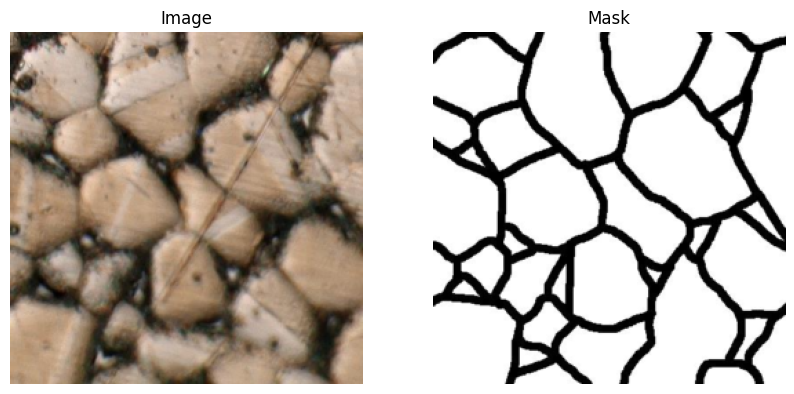

In [43]:
import matplotlib.pyplot as plt

# Assuming train_transformer and test_transformer are defined appropriately

# Get a single data sample
index = 10  # You can change this index to visualize different samples
sample_img, sample_mask = dataset[index]

# Convert sample_img and sample_mask from PyTorch tensors to numpy arrays
sample_img = sample_img.numpy().transpose((1, 2, 0))  # (C, H, W) to (H, W, C)
sample_img = sample_img.astype(float)  # Convert to float for normalization
sample_img /= 255.0  # Normalize to range [0, 1]

sample_mask = sample_mask.squeeze().numpy()  # Remove singleton dimension

# Display the image and mask
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title('Image')
plt.axis('off')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()


In [ ]:
# c1 = len(dataset)
# print(c1)
# # train_dataset[0][0] = input image
# # train_dataset[0][1] = ground truth mask

# image,mask=dataset[0]
# print(f"Image shape:{image.shape}")
# print(f"Mask shape:{mask.shape}")
# print(f"Image tensor:{image}")
# print(f"Mask tensor:{mask}")

In [44]:
import torch
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(20)

# Split the dataset into train and validation sets (80-10-10)
train_size = int(0.80 * len(dataset))
r = len(dataset) - train_size
val_size = int(0.5 * r)
test_size = int(0.5 * r)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [45]:
from torch.utils.data import random_split, DataLoader

batch_size = 1


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
#

In [ ]:
# print(input_data.unsqueeze(0).shape)

In [ ]:
# input_data =  image
# input_data = input_data.unsqueeze(0)
# input_data = input_data.cuda(non_blocking=True).float()

In [ ]:
# print(input_data)

In [ ]:
# input_data.shape

In [ ]:
# train_image = test_dataset[0][0].unsqueeze(0).cuda(non_blocking=True).float()
# predict = model(train_image)
# # predict = model(x)

In [ ]:
# print(predict.shape)

In [ ]:
# print(predict)

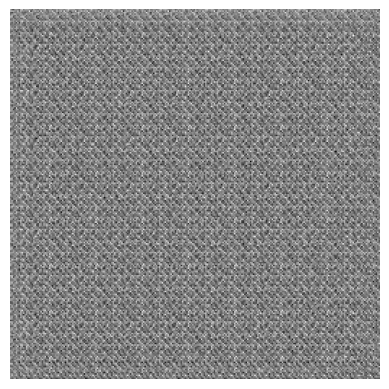

In [24]:
import torch
import matplotlib.pyplot as plt
# Convert the tensor to a numpy array
mask_np = predict.cpu().detach().numpy()

# Plot the image in black and white
plt.imshow(mask_np.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# print(len(test_dataset))

#Train

In [26]:
from torch.optim import Adam
# import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0)
# Try DiceFocalLoss, FocalLoss, DiceCELoss
# criterion = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
criterion = nn.BCELoss()

In [63]:
from tqdm import tqdm
from statistics import mean
import torch

# Training loop
num_epochs = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

total_loss = []
best_val_loss = float('inf')  # Initialize with a large value
patience = 3  # Number of epochs to wait for improvement
wait = 0  # Counter for patience
model.train()

for epoch in range(num_epochs):
    loss_list = []

    for i, data in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        images, targets = data
        images, targets = images.cuda(non_blocking=True).float(), targets.cuda(non_blocking=True).float()
        out = model(images)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    # Calculate mean training loss
    train_loss = mean(loss_list)
    total_loss.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss_list = []
        for i, data in enumerate(val_dataloader):
            images, targets = data
            images, targets = images.cuda(non_blocking=True).float(), targets.cuda(non_blocking=True).float()
            out = model(images)
            val_loss = criterion(out, targets)
            val_loss_list.append(val_loss.item())
        val_loss = mean(val_loss_list)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss training: {train_loss}')
    print(f'Mean loss validation: {val_loss}')

    # # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0  # Reset patience counter
        # Save the model if validation loss improves
        torch.save(model.state_dict(), "/content/drive/MyDrive/465 Project/VMUnet Checkpoints/temp.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping...")
            break

    model.train()  # Switch back to training mode


100%|██████████| 384/384 [00:51<00:00,  7.39it/s]


EPOCH: 0
Mean loss training: 0.2792794471218561
Mean loss validation: 0.2867766770844658


100%|██████████| 384/384 [00:53<00:00,  7.19it/s]


EPOCH: 1
Mean loss training: 0.2790621544700116
Mean loss validation: 0.28641038201749325


100%|██████████| 384/384 [00:53<00:00,  7.13it/s]


EPOCH: 2
Mean loss training: 0.2796531531882162
Mean loss validation: 0.286383924074471


100%|██████████| 384/384 [00:53<00:00,  7.24it/s]


EPOCH: 3
Mean loss training: 0.27947751875035465
Mean loss validation: 0.286499557706217


100%|██████████| 384/384 [00:52<00:00,  7.35it/s]


EPOCH: 4
Mean loss training: 0.2795153185337161
Mean loss validation: 0.2862743105118473


100%|██████████| 384/384 [00:52<00:00,  7.34it/s]


EPOCH: 5
Mean loss training: 0.2797040654889618
Mean loss validation: 0.2858164260784785


In [69]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/465 Project/VMUnet Checkpoints/VMUnet_ASPP.pth")

# Load & Evaluation

In [70]:
model = VMUNet(
            num_classes=1,
            input_channels=3,
            depths= [2,2,9,2],
            depths_decoder=[2,2,2,1],
            drop_path_rate=0.2,
            load_ckpt_path=pretrained_path,
        ).cuda()
model.load_state_dict(torch.load( "/content/drive/MyDrive/465 Project/VMUnet Checkpoints/VMUnet_ASPP.pth"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/465 Project/VMUnet Checkpoints/seed60_10epochFIXED.pth"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/465 Project/VMUnet Checkpoints/seed50_10epoch.pth"))

<All keys matched successfully>

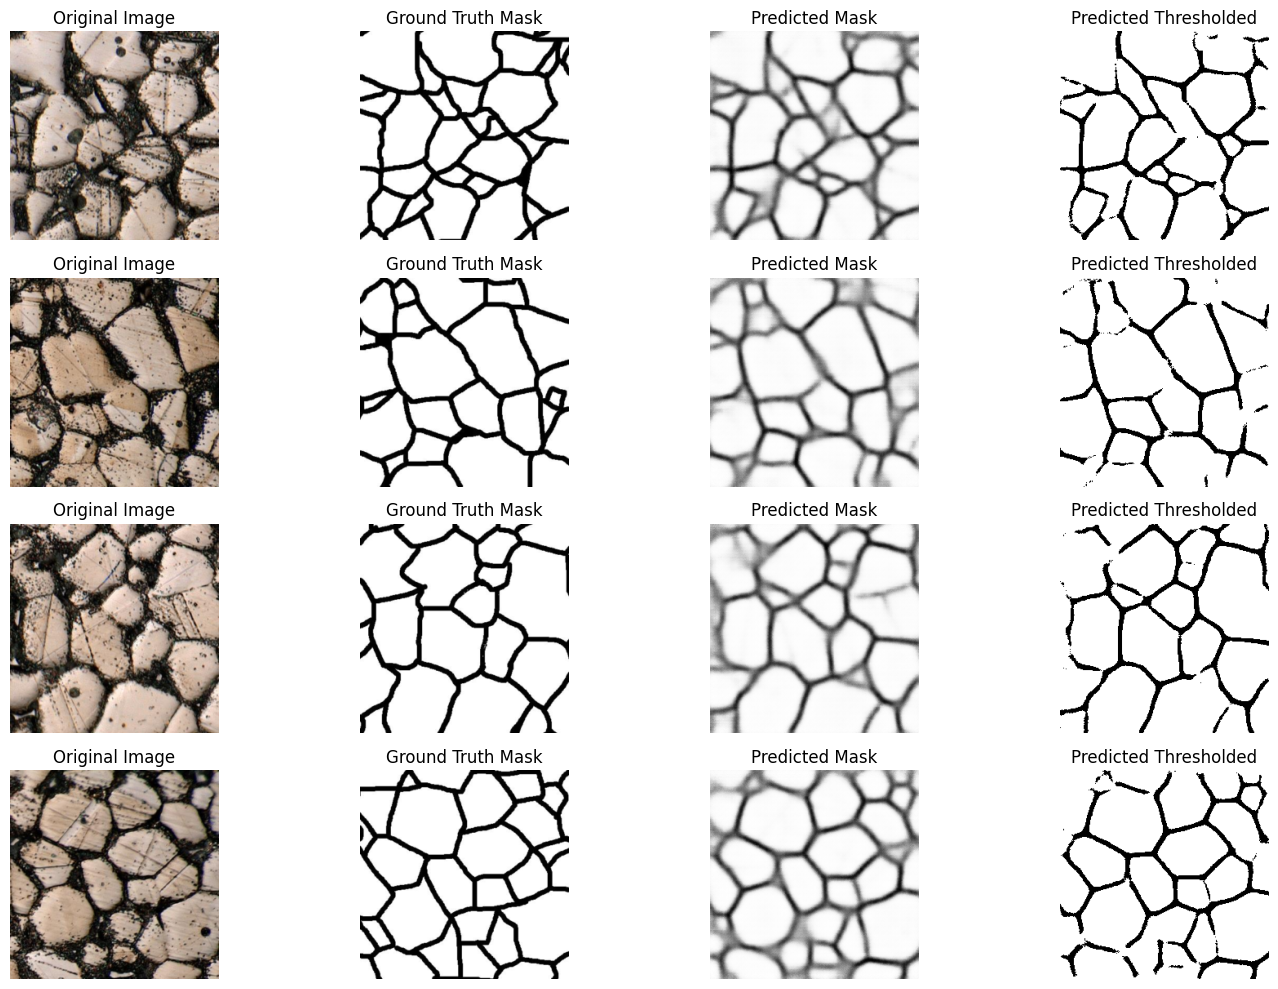

In [46]:
import matplotlib.pyplot as plt

# Define the number of images you want to display
num_images = 4

# Set up the figure with appropriate size
plt.figure(figsize=(15, 10))

# Loop over the number of images you want to display
for i in range(num_images):
    # Get the image and mask from the dataset
    image, mask = test_dataset[i]

    # Convert sample_img and sample_mask from PyTorch tensors to numpy arrays
    sample_img = image.numpy().transpose((1, 2, 0))  # (C, H, W) to (H, W, C)
    sample_img = sample_img.astype(float)  # Convert to float for normalization
    sample_img /= 255.0  # Normalize to range [0, 1]

    sample_mask = mask.squeeze().numpy()  # Remove singleton dimension

    # Plot the original image
    plt.subplot(num_images, 4, 4*i + 1)
    plt.imshow(sample_img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot the ground truth mask
    plt.subplot(num_images, 4, 4*i + 2)
    plt.imshow(sample_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(num_images, 4, 4*i + 3)
    input_data = image.unsqueeze(0).cuda(non_blocking=True).float()
    model.eval()
    with torch.no_grad():
        predict = model(input_data)
        mask_np = predict.cpu().detach().numpy()
    plt.imshow(mask_np.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Plot the thresholded predicted mask
    plt.subplot(num_images, 4, 4*i + 4)
    pred_tensor = (predict > 0.5).cpu().numpy().astype('float32')  # Convert to numpy array
    plt.imshow(pred_tensor.squeeze(), cmap='gray')
    plt.title('Predicted Thresholded')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [71]:
import numpy as np

total_dice_score = 0.0
total_hd6 = 0.0
total_num_samples = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
cnt = 0

with torch.no_grad():
    for i, data in enumerate(tqdm(test_dataloader)):
        cnt += 1
        images, targets = data
        images, targets = images.cuda(non_blocking=True).float(), targets.cuda(non_blocking=True).float()
        outputs = model(images)
        predicted_masks = outputs

        # Assuming ground truth masks come from targets
        ground_truth_masks = targets # Assuming targets are in shape [B, C, H, W]

        # Move tensors to the same device
        predicted_masks = predicted_masks.to(device)
        ground_truth_masks = ground_truth_masks.to(device)

        for ind in range(len(predicted_masks)):
            pred_np = (predicted_masks[ind]>0.5).cpu().numpy()
            gt_np = (ground_truth_masks[ind]>0.5).cpu().numpy()

            dice_score, hd6 = calculate_metric_percase(pred_np, gt_np)

            total_dice_score += dice_score
            total_hd6 += hd6

    total_num_samples = cnt * test_dataloader.batch_size
    print(f"\nTest Set Size: {total_num_samples}")
    average_dice_score = total_dice_score / total_num_samples

    print(f"Final Dice score on test set: {average_dice_score}")


100%|██████████| 48/48 [00:04<00:00, 10.42it/s]


Test Set Size: 48
Final Dice score on test set: 0.9190575479963607
